In [1]:
from CookieTTS._2_ttm.flowtts.model import FlowTTS
from CookieTTS._2_ttm.flowtts.model import load_model
from CookieTTS._2_ttm.flowtts.hparams import create_hparams
from CookieTTS.utils.audio.stft import TacotronSTFT, STFT
from CookieTTS.utils.text import text_to_sequence

import sys
sys.path.append('../_4_mtw/waveglow') # add WaveGlow to System path for easier importing
import numpy as np
import torch

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def plot_data(data, title=None, figsize=(20, 3.5)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        if title:
            axes[i].set_title(title[i])
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [3]:
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Speaker ID = tensor([5], device='cuda:0')
G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\best_model
On iter 750
Text: `Flow T T S.`        [mean -5.040038] [max 1.677416] [min -11.309250]
Text: `Sssssssssss`        [mean -5.178429] [max 2.682817] [min -11.432816]
Text: `Twilight Sparkle? Are you sure?` [mean -5.106183] [max 1.678501] [min -11.396809]


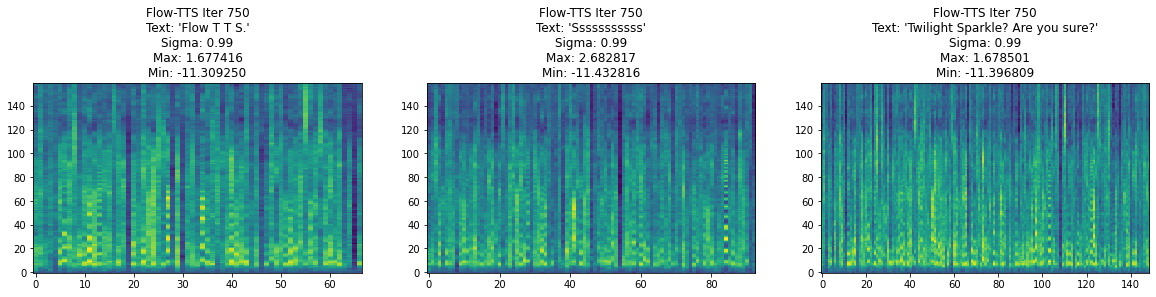

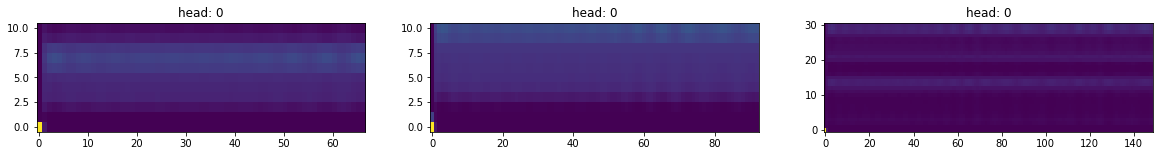

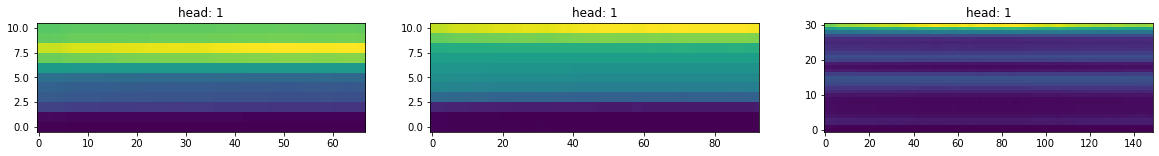

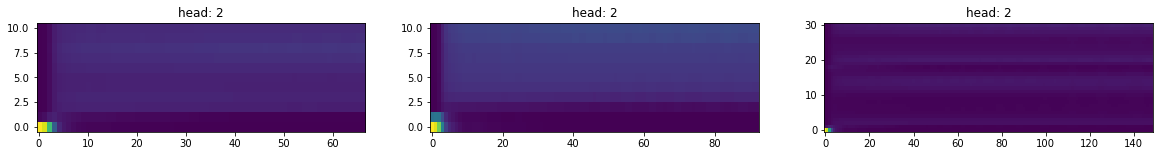

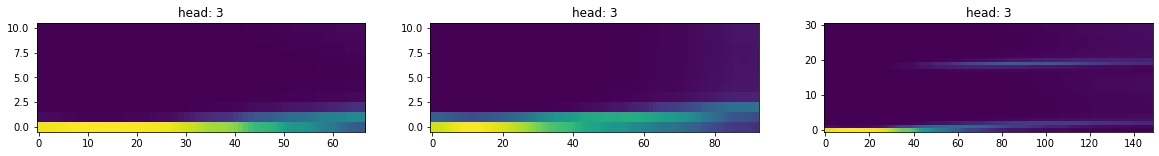

In [14]:
checkpoint_paths = [
    r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\best_model",
]

texts = [
    "Flow T T S.",
    "Sssssssssss",
    "Twilight Sparkle? Are you sure?",
]

sigma = [0.99]

# Speaker IDs
speaker_ids = torch.LongTensor([5,]).cuda()
print('Speaker ID =', speaker_ids)
# Generate
with torch.no_grad():
    for sigma_ in sigma:
        for i, checkpoint_path in enumerate(checkpoint_paths):
            print(checkpoint_path)
            checkpoint = torch.load(checkpoint_path)
            iteration = checkpoint['iteration']
            print(f"On iter {iteration}")
            model = load_model(hparams)
            model.load_state_dict(checkpoint['state_dict'])
            _ = model.cuda().eval()
            mel_outputs = []
            alignments = []
            titles=[]
            for text in texts:
                sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
                sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
                mel_output, alignment, *_ = model.inference(sequence, speaker_ids, sigma=sigma_)
                mel_output = (mel_output-3.5)*8 # inverse transform magnitudes from -1 -> 1 to -11.5 -> 4.5
                alignment = alignment.transpose(2, 3)
                print(f'Text: {"`"+text+"`":20} [mean {mel_output.mean().item():.6f}] [max {mel_output.max().item():.6f}] [min {mel_output.min().item():.6f}]')
                mel_outputs.append(mel_output)
                alignments.append(alignment)
                titles.append(f"Flow-TTS Iter {iteration}\nText: '{text}'\nSigma: {sigma_}\nMax: {mel_output.max().item():.6f}\nMin: {mel_output.min().item():.6f}")
            plot_data((*[x.float().cpu().numpy()[0] for x in mel_outputs],), title=titles)
            for head_id in range(alignments[0].shape[1]):
                plot_data((*[x[0][head_id].float().cpu().numpy() for x in alignments],), title=[f'head: {head_id}',]*len(alignments), figsize=(20, 2))

In [5]:
from CookieTTS.utils.model.utils import get_mask_from_lengths
import torch
get_mask_from_lengths(torch.LongTensor((1,5,6)).cuda())

tensor([[ True, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True]], device='cuda:0')

In [6]:
import torch
q = torch.rand(1,8,5)
k = torch.rand(1,16,5)
o = q.matmul(k.transpose(-1, -2))
o.shape

torch.Size([1, 8, 16])

torch.Size([1, 256, 2])


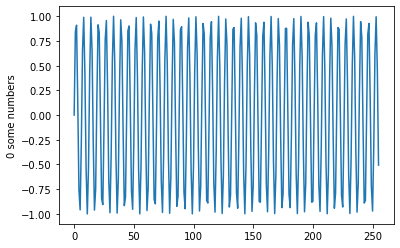

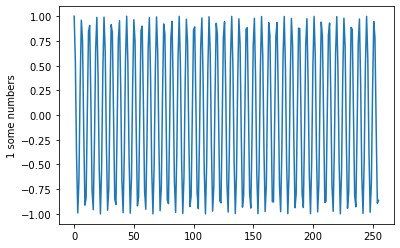

In [7]:
from CookieTTS._2_ttm.flowtts.fastpitch.transformer import PositionalEmbedding
pos_emb_layer = PositionalEmbedding(2).cuda().half()
dec_T_max = 256
pos_emb = torch.arange(dec_T_max, device="cuda", dtype=torch.float16)
pos_emb = pos_emb_layer(pos_emb, bsz=1)
print(pos_emb.shape)
for i in range(pos_emb.shape[2]):
    x = [x[i].item() for x in pos_emb[0]]
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.plot(x)
    plt.ylabel(f'{i} some numbers')
    plt.show()

## Other stuff

In [8]:
import numpy as np
sigma = 1.0
0.5 * np.log(2 * np.pi) + np.log(sigma)

0.9189385332046727

In [9]:
(0.5 * np.log(2 * np.pi) + np.log(sigma))*10

9.189385332046726

In [10]:
print(
    f"{.9189385332046727:6.4}",
    f"{9.189385332046727:6.4}",
    f"{99.189385332046727:6.4}",
    f"{999.189385332046727:6.4}",
    f"{-9.189385332046727:6.4}",
     sep='\n',)

0.9189
 9.189
 99.19
 999.2
-9.189


In [11]:
2.718281828459**6

403.42879349269464